# A Tutorial on Advanced PyTorch Techniques

**Companion Notebook for the Advanced PyTorch Presentation in this Repo**

This notebook provides a hands-on walkthrough of the concepts discussed in the presentation. Here, you'll find executable code for custom modules, loss functions, advanced training loops, and more. The goal is to bridge the gap between theory and implementation, enabling you to apply these techniques directly into your code.

## Section 1: Foundations Recap

### Tensors and Autograd

Everything in PyTorch is built upon the `Tensor`. Let's start with a quick refresher on creating tensors and tracking gradients with `autograd`.

In [1]:
import torch

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Create tensors, specifying that we want to track their gradients
x = torch.randn(3, 1, requires_grad=True, device=device)
w = torch.randn(1, 3, requires_grad=True, device=device)
b = torch.randn(1, 1, requires_grad=True, device=device)

# Build a simple computation graph (y = w * x + b)
y = torch.matmul(w, x) + b

# Define a dummy loss
loss = torch.sum(y)

# Backpropagate to compute gradients
loss.backward()

# The gradients are now stored in the .grad attribute of each tensor
print("Gradient for w:", w.grad)
print("Gradient for b:", b.grad)

Using device: cpu
Gradient for w: tensor([[-1.1562,  1.3740,  0.4931]])
Gradient for b: tensor([[1.]])


### Working with CUDA

While `device = 'cuda'` works, it's useful to understand the specifics of GPU operations. The most common source of error is a "device mismatch," where tensors involved in an operation live on different devices (e.g., one on CPU, one on GPU).

In [ ]:
if device == 'cuda':
    # Tensors must be explicitly moved to the GPU
    cpu_tensor = torch.randn(3, 3)
    print(f"CPU Tensor Device: {cpu_tensor.device}")
    
    gpu_tensor = cpu_tensor.to(device)
    print(f"GPU Tensor Device: {gpu_tensor.device}")
    
    # This will cause a runtime error:
    try:
        result = cpu_tensor + gpu_tensor
    except RuntimeError as e:
        print(f"\nError: {e}")
    
    # The fix is to ensure all tensors are on the same device
    gpu_tensor_2 = torch.randn(3, 3).to(device)
    result = gpu_tensor + gpu_tensor_2
    print(f"\nSuccessful operation. Result device: {result.device}")
    
    # Asynchronous Execution: CUDA operations are asynchronous.
    # This means the Python code continues executing without waiting for the GPU operation to finish.
    # To accurately benchmark code, you need to synchronize.
    import time
    
    start_time = time.time()
    large_tensor_a = torch.randn(10000, 10000, device=device)
    large_tensor_b = torch.randn(10000, 10000, device=device)
    c = large_tensor_a @ large_tensor_b
    torch.cuda.synchronize() # Wait for the GPU operation to complete
    end_time = time.time()
    
    print(f"\nTime with synchronization: {end_time - start_time:.4f} seconds")
else:
    print("CUDA not available. Skipping CUDA-specific section.")

### The `nn.Module`

The `nn.Module` is the cornerstone of building models. It automatically tracks parameters and provides helpful utilities.

In [2]:
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        # Define layers. Their parameters are automatically registered.
        self.layer1 = nn.Linear(in_features=10, out_features=20)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(in_features=20, out_features=5)
    
    def forward(self, x):
        # Define the data flow
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

# Instantiate the model and move it to the selected device
model = SimpleModel().to(device)

# PyTorch provides a clean summary of the model architecture
print(model)

# You can easily inspect all model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

SimpleModel(
  (layer1): Linear(in_features=10, out_features=20, bias=True)
  (activation): ReLU()
  (layer2): Linear(in_features=20, out_features=5, bias=True)
)
layer1.weight torch.Size([20, 10])
layer1.bias torch.Size([20])
layer2.weight torch.Size([5, 20])
layer2.bias torch.Size([5])


## Section 2: Custom Architectures

### Example: Custom ResNet Block

Research often requires implementing architectures that don't fit into a simple sequential pattern. A residual block, with its skip connection, is a perfect example. We define the layers in `__init__` and the complex data flow (including the addition of the skip connection) in `forward`.

As a refresher, the basic block in ResNet architecture looks like this:

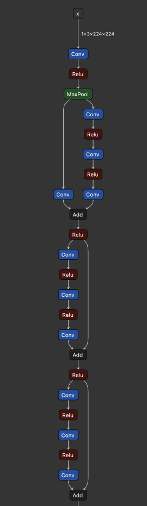

_Snippet of a ResNet50 model's skip connection architecture visualized using Netron_

In [3]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut path to handle dimension changes (if stride is not 1 or channels change)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # The skip connection is just an addition
        out = F.relu(out)
        return out

# Test the block with a random input tensor
input_tensor = torch.randn(2, 64, 32, 32).to(device) # (batch, channels, height, width)
resnet_block = BasicBlock(in_channels=64, out_channels=128, stride=2).to(device)
output_tensor = resnet_block(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)

Input shape: torch.Size([2, 64, 32, 32])
Output shape: torch.Size([2, 128, 16, 16])


### Example: Multi-Branch (Inception-like) Module

This module processes an input through several parallel convolutional paths and then concatenates the results.

In [4]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels_1x1, out_channels_3x3, out_channels_5x5):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_channels_1x1, kernel_size=1)
        self.branch2 = nn.Conv2d(in_channels, out_channels_3x3, kernel_size=3, padding=1)
        self.branch3 = nn.Conv2d(in_channels, out_channels_5x5, kernel_size=5, padding=2)
    
    def forward(self, x):
        # Process input through each branch
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        # Concatenate results along the channel dimension (dim=1)
        return torch.cat([out1, out2, out3], dim=1)

input_tensor = torch.randn(2, 64, 32, 32).to(device)
inception_block = InceptionModule(64, 32, 48, 16).to(device)
output_tensor = inception_block(input_tensor)

print("Input shape:", input_tensor.shape)
# The output channels should be the sum of the branch output channels (32 + 48 + 16 = 96)
print("Output shape:", output_tensor.shape)

Input shape: torch.Size([2, 64, 32, 32])
Output shape: torch.Size([2, 96, 32, 32])


## Section 3: Custom Loss Functions

### Example: Triplet Loss

Most custom losses can be implemented as simple Python functions that use differentiable PyTorch operations. Here is the triplet loss for metric learning.

In [5]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    """Calculates the triplet loss."""
    distance_positive = F.pairwise_distance(anchor, positive, p=2)
    distance_negative = F.pairwise_distance(anchor, negative, p=2)
    
    # We want d(a, p) + margin < d(a, n)  =>  d(a, p) - d(a, n) + margin < 0
    losses = F.relu(distance_positive - distance_negative + margin)
    
    return losses.mean()

# Create dummy embeddings
anchor_embedding = torch.randn(10, 128, device=device)
positive_embedding = torch.randn(10, 128, device=device)
negative_embedding = torch.randn(10, 128, device=device)

# Calculate loss
loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
print(f"Triplet Loss: {loss.item()}")

Triplet Loss: 1.013861060142517


### Example: Focal Loss

Focal loss is another great example of a custom loss, designed to handle class imbalance by focusing on hard-to-classify examples. It's a modification of standard cross-entropy.

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs are model logits, targets are class indices
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Dummy data
logits = torch.randn(10, 5, device=device) # 10 samples, 5 classes
labels = torch.randint(0, 5, (10,), device=device)

focal_loss_fn = FocalLoss()
loss = focal_loss_fn(logits, labels)
print(f"Focal Loss: {loss.item()}")

Focal Loss: 0.3142664432525635


## Section 4: Advanced Training Techniques

### Optimizers and Schedulers

Choosing the right optimizer and learning rate schedule is critical. `AdamW` is the modern default for many tasks. `CosineAnnealingLR` is a powerful and popular scheduler.

In [7]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

model = SimpleModel().to(device)

# The recommended optimizer for Transformers and other modern architectures
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# A scheduler that smoothly varies the learning rate
# T_max is the number of iterations for one half of a cosine cycle
scheduler = CosineAnnealingLR(optimizer, T_max=100) 

print("Initial Learning Rate:", scheduler.get_last_lr()[0])

# Simulate 10 training steps
for i in range(10):
    # In a real loop, you'd do: optimizer.step(); scheduler.step()
    scheduler.step()

print("Learning Rate after 10 steps:", scheduler.get_last_lr()[0])

Initial Learning Rate: 0.001
Learning Rate after 10 steps: 0.0009755282581475767


/Users/jainarchita/miniconda3/envs/ai_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


### Gradient Accumulation

This technique lets you simulate a larger batch size than your GPU memory can handle. It's essential for training large models.

In [8]:
accumulation_steps = 4
optimizer = AdamW(model.parameters(), lr=1e-3)
dummy_dataloader = [(torch.randn(8, 10), torch.randn(8,5)) for _ in range(16)] # Batch size of 8

optimizer.zero_grad() # Reset gradients once before the loop

for i, (inputs, targets) in enumerate(dummy_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    loss = nn.MSELoss()(outputs, targets)
    
    # Scale loss for accumulation
    loss = loss / accumulation_steps
    
    # Backward pass (gradients are accumulated)
    loss.backward()
    
    # Update weights only after accumulating gradients for `accumulation_steps` batches
    if (i + 1) % accumulation_steps == 0:
        print(f"Step {i+1}: Optimizer step (effective batch size: {8 * accumulation_steps})")
        optimizer.step()       # Update weights
        optimizer.zero_grad()  # Reset gradients for the next accumulation cycle

Step 4: Optimizer step (effective batch size: 32)
Step 8: Optimizer step (effective batch size: 32)
Step 12: Optimizer step (effective batch size: 32)
Step 16: Optimizer step (effective batch size: 32)


### Mixed Precision Training with `torch.cuda.amp`

Automatic Mixed Precision (AMP) significantly speeds up training and reduces memory usage on modern NVIDIA GPUs by using `float16` for certain operations. The implementation is remarkably simple.

In [9]:
from torch.cuda.amp import GradScaler, autocast

# Only runs on CUDA-enabled devices
if device == 'cuda':
    model = SimpleModel().to(device)
    optimizer = AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    
    # Create a gradient scaler
    scaler = GradScaler()
    
    # Dummy data
    inputs = torch.randn(8, 10, device=device)
    targets = torch.randn(8, 5, device=device)
    
    optimizer.zero_grad()
    
    # Use the autocast context manager
    with autocast():
        output = model(inputs)
        loss = loss_fn(output, targets)
    
    # scaler.scale(loss) scales the loss. Gradients are unscaled by scaler.step().
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    print("Mixed precision training step completed.")
else:
    print("AMP requires a CUDA-enabled GPU.")

AMP requires a CUDA-enabled GPU.


### Distributed Training with `DistributedDataParallel` (DDP)

`DistributedDataParallel` (DDP) is the standard, most performant way to do multi-GPU training. Unlike `DataParallel`, it spawns a separate process for each GPU, eliminating the bottlenecks of the older method.

**Important:** DDP scripts cannot be run directly inside a notebook because they require multiple processes to be launched from a script. Below is a complete, self-contained Python script. To run it:

1.  Save the code below as a Python file (e.g., `ddp_example.py`).
2.  From your terminal, run it using `torchrun`. If you have 2 GPUs, you would run:
    ```bash
    torchrun --nproc_per_node=2 ddp_example.py
    ```

In [12]:
%%writefile ddp_example.py
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

def setup(rank, world_size):
    """Initializes the distributed process group."""
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    # Initializes the distributed backend (nccl is recommended for NVIDIA GPUs)
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)

def cleanup():
    """Cleans up the distributed process group."""
    dist.destroy_process_group()

class TrivialDataset(Dataset):
    """A simple dataset for demonstration purposes."""
    def __init__(self, size=128):
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return torch.randn(10), torch.randn(5)

def main():
    # DDP environment variables are set by torchrun
    local_rank = int(os.environ["LOCAL_RANK"])
    world_size = int(os.environ["WORLD_SIZE"])
    
    setup(local_rank, world_size)
    
    print(f"Running DDP on rank {local_rank}.")

    # 1. Create model and move it to the correct device for this process
    model = nn.Linear(10, 5).to(local_rank)
    # 2. Wrap the model with DDP
    ddp_model = DDP(model, device_ids=[local_rank])

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(ddp_model.parameters(), lr=0.001)

    # 3. Use DistributedSampler to ensure each process gets a different slice of data
    dataset = TrivialDataset()
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=local_rank)
    dataloader = DataLoader(dataset, batch_size=8, sampler=sampler)

    # Training loop
    for epoch in range(2):
        # The sampler needs to be informed of the current epoch
        sampler.set_epoch(epoch)
        for data, labels in dataloader:
            data, labels = data.to(local_rank), labels.to(local_rank)
            
            optimizer.zero_grad()
            outputs = ddp_model(data)
            loss = loss_fn(outputs, labels)
            loss.backward() # Gradients are automatically averaged across all processes
            optimizer.step()
        print(f"Rank {local_rank}, Epoch {epoch}, Loss: {loss.item()}")

    cleanup()

if __name__ == "__main__":
    main()

Overwriting ddp_example.py


## Section 5: Advanced PyTorch Utilities

### Hooks

Hooks are powerful tools for debugging and analysis, allowing you to inspect activations or gradients without modifying your model's code. Here, we'll use a forward hook to get the output of an intermediate layer.

In [ ]:
activation_features = {}

def get_activation(name):
    # This is the hook function
    def hook(model, input, output):
        activation_features[name] = output.detach()
    return hook

model = SimpleModel().to(device)

# Register a forward hook on the first linear layer's output (after the activation)
model.activation.register_forward_hook(get_activation('relu1'))

# Run a forward pass
output = model(torch.randn(1, 10, device=device))

# The hook has now captured the output of the ReLU layer
print("Shape of captured ReLU activation:", activation_features['relu1'].shape)

### `torch.compile` (PyTorch 2.x)

The simplest way to get a significant performance boost. `torch.compile` JIT-compiles your model into an optimized graph, often with no code changes required.

In [ ]:
model = SimpleModel().to(device)

# This single line can provide significant speedups
compiled_model = torch.compile(model)

# Now, just use the compiled model as you would the original
input_tensor = torch.randn(16, 10, device=device)
output = compiled_model(input_tensor)

print("Forward pass with compiled model completed.")
print("Output shape:", output.shape)

## Section 6: Specialized Architectures (Further Reading)

While implementing these from scratch is beyond the scope of this tutorial, PyTorch has a rich ecosystem of libraries that provide optimized building blocks for specialized domains.

- **Graph Neural Networks:** For working with graph-structured data, the go-to library is [**PyTorch Geometric**](https://pytorch-geometric.readthedocs.io/en/latest/).

- **Transformers:** For NLP and Vision Transformers, the [**Hugging Face `transformers`**](https://huggingface.co/docs/transformers/index) library is the undisputed industry standard, providing thousands of pre-trained models and easy-to-use APIs.

- **Reinforcement Learning & Meta-Learning:** PyTorch's dynamic graph is ideal for these domains. While there are many libraries, understanding the core principles from this notebook will allow you to build custom training loops required for RL and MAML.

## Conclusion

This notebook has covered the practical implementation of several advanced PyTorch techniques. By mastering `nn.Module` subclassing, custom loss functions, and modern training strategies, you can build custom NN architecture for your Deep Learning Experiments.